# Parsing measurement data

In [1]:
import math

def lmap(f,x):
    return list(map(f,x))

def process_raw_decay_data(name, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{name}.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 5
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            if (float(row[1]) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])


            if (float(row[1]) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])

                peaks.append((endPeak+startPeak)/2)                

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{name}_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*math.pi/3) + "\n")

        return f"./outputs/{name}_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./Data/{name}_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                if(flAverage < cutoff_val):
                    res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{name}_PROCESSED.csv"


In [2]:
unprocessed_names = [
    "nomag_1",
    "mag_1_r=85mm"
]
processed_paths = []
for name in unprocessed_names:
    out_path = process_raw_decay_data(name, -1, 0.7)
    processed_paths.append(out_path)

# Fitting for $\alpha$, $\gamma$, $c_1$

$$
\omega(t) = - \sqrt{\frac{\alpha}{\gamma}} \tan{(\sqrt{\alpha\gamma}(t+c_1))}
$$

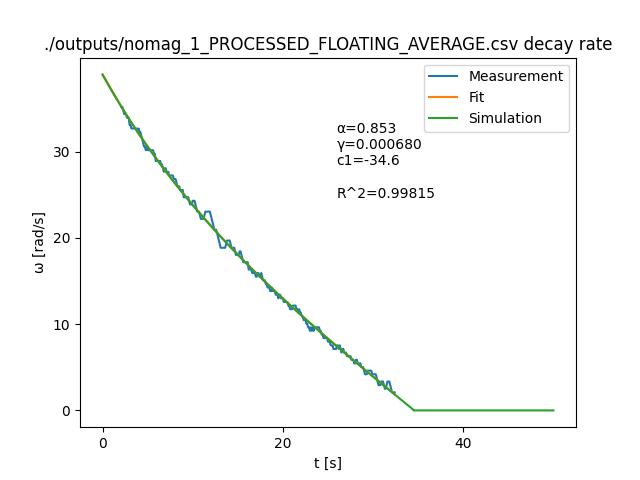

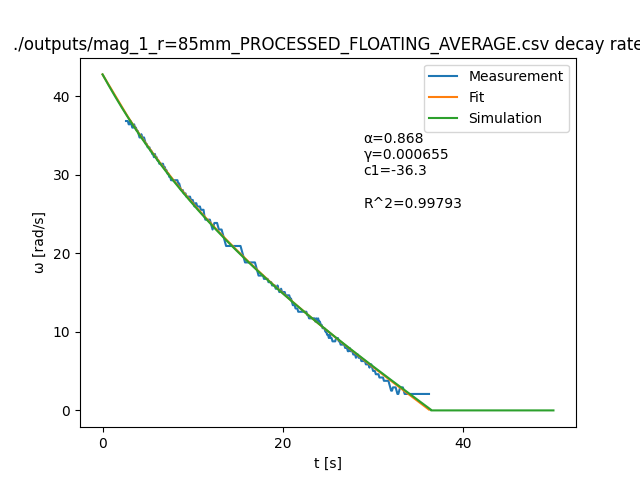

In [3]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

alphas = []
gammas = []
cs = []
omega_0s = []
R_squares = []

for i in range(len(processed_paths)):
    plt.figure()

    path = processed_paths[i]
    with open(path, "r") as read:
        # DATA
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[2]), data)

        plt.plot(xdata, ydata, label="Measurement")
        omega_0s.append(ydata[0])

        # FIT
        def ω(time, alpha, gamma, c_1):
            return [
                - math.sqrt(alpha / gamma)
                * math.tan(math.sqrt(alpha * gamma) * (t + c_1))
                for t in time
            ]

        [alpha, gamma, c], pcov = opt.curve_fit(
            ω,
            xdata,
            ydata,
            bounds=(
                [0, 0, -math.inf],  # min
                [1, 0.01, 0],  # max
            ),
            p0=[0.21, 0.00025, -170],
            max_nfev=10000
        )
        perr = np.sqrt(np.diag(pcov))

        # calc R^2
        residuals = np.array(ydata) - np.array(ω(xdata, *[alpha, gamma, c]))
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((np.array(ydata) - np.mean(ydata))**2)
        r_squared = 1 - (ss_res / ss_tot)

        alphas.append(alpha)
        gammas.append(gamma)
        cs.append(c)
        R_squares.append(r_squared)

        plt.text(max(xdata) * 0.8, max(ydata) * 0.7, f"α={alpha:.3f}\nγ={gamma:.6f}\nc1={c:.1f}\n\nR^2={r_squared:.5f}")
        plt.plot([0, *xdata], ω([0, *xdata], alpha, gamma, c), label="Fit")
        # print(ω([0], alpha, gamma, c))

    name = unprocessed_names[i]
    with open(f"sim/{name}_SIM.csv", "r") as read:
        # SIM
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[1]), data)

        plt.plot(xdata, ydata, label="Simulation")

    plt.title(f"{path} decay rate")

    plt.xlabel("t [s]")
    plt.ylabel("ω [rad/s]")
    plt.xticks(np.arange(min(xdata), max(xdata) + 1, 20.0))
    plt.yticks(np.arange(min(ydata), max(ydata) + 1, 10.0))

    plt.legend()

    


# $c_1$ in relation to $\alpha$ and $\gamma$ in our measurements

In [4]:
print("Averages:")
print(f"α={np.average(alphas)}")
print(f"γ={np.average(gammas)}")
print(f"c1={np.average(cs)}")
print(f"R^2={np.average(R_squares)}")

Averages:
α=0.8604501307857891
γ=0.0006671803832953829
c1=-35.45070783280049
R^2=0.9980374841922129
